In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

# Data Preprocessing

In [2]:
# fetch the data
bitcoin = yf.Ticker("BTC-USD")
bitcoin

yfinance.Ticker object <BTC-USD>

In [3]:
#Get historical data
bitcoin_data = bitcoin.history(start ="2015-01-01", end=date.today(), interval="1d")

bitcoin_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-09,33416.976562,37537.371094,32475.865234,37345.121094,53972919008,0,0
2021-06-10,37389.515625,38334.324219,35847.593750,36702.597656,43576032854,0,0
2021-06-11,36697.031250,37608.695312,36044.449219,37334.398438,38699736985,0,0
2021-06-12,37340.144531,37408.925781,34728.191406,35552.515625,37924228550,0,0
2021-06-13,35555.789062,39322.781250,34864.109375,39097.859375,40669112838,0,0


### Data Visualization

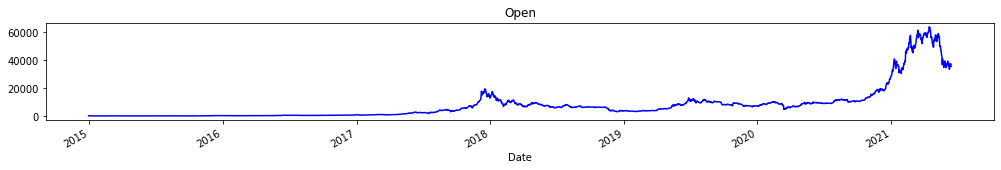

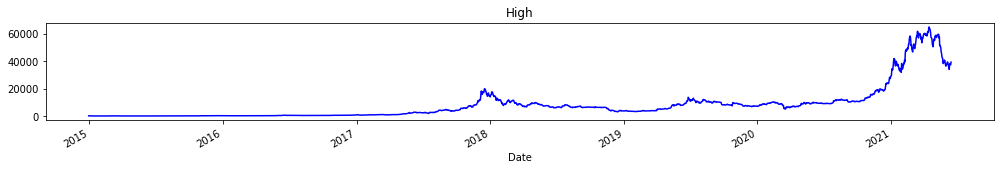

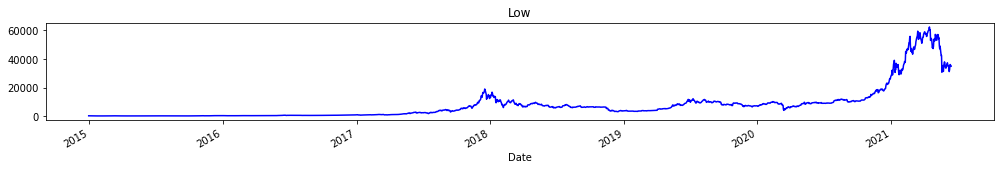

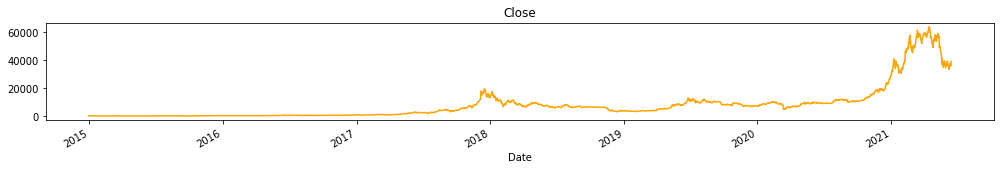

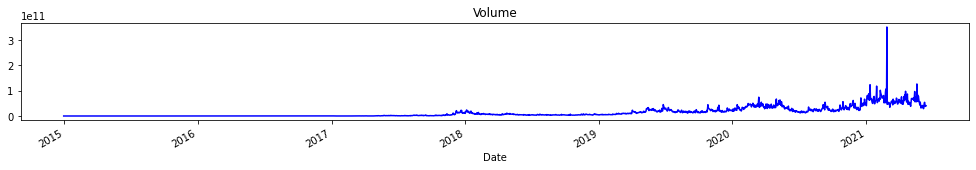

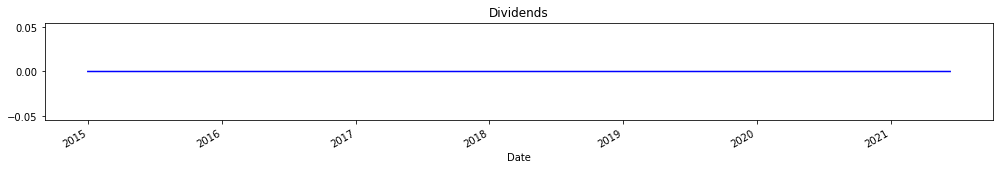

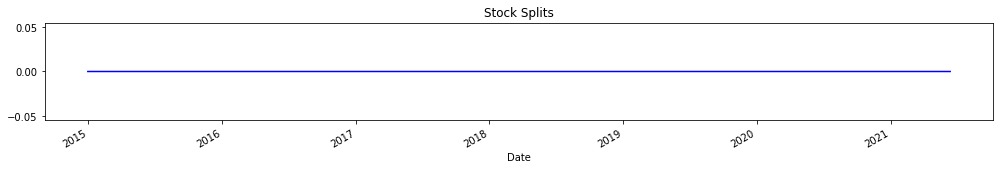

In [4]:
%matplotlib inline

for col in bitcoin_data.columns:
    color="orange" if col == "Close" else "blue"
    bitcoin_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
bitcoin_data = bitcoin_data.reset_index()
bitcoin_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-12-31,310.914001,320.192993,310.210999,320.192993,13942900,0,0
1,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,0,0
2,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0,0
3,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,0,0
4,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,0,0


In [7]:
#check if date is in datetime format
bitcoin_data.Date.dtype

dtype('<M8[ns]')

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [8]:
#Extracting the date and close price columns
bitcoin_df = bitcoin_data[["Date", "Close"]]
bitcoin_df.head()

,Date,Close
0,2014-12-31,320.192993
1,2015-01-01,314.248993
2,2015-01-02,315.032013
3,2015-01-03,281.082001
4,2015-01-04,264.195007


In [9]:
#rename the columns
bitcoin_df = bitcoin_df.rename(columns={'Date': 'ds', 'Close': 'y'})
bitcoin_df.head()

,ds,y
0,2014-12-31,320.192993
1,2015-01-01,314.248993
2,2015-01-02,315.032013
3,2015-01-03,281.082001
4,2015-01-04,264.195007


### Splitting the Data

In [10]:
index = int(0.8 * bitcoin_df.shape[0])
train_df = bitcoin_df[:index]
test_df = bitcoin_df[index:]

In [11]:
print(train_df.shape)
print(test_df.shape)

(1882, 2)
(471, 2)


### Hyperparameter Tuning

In [12]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [14]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [13]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [14]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1913,2022-09-30,25949.510494,-181280.494306,242911.582949
1914,2022-10-31,25894.829024,-190406.033903,253899.199715
1915,2022-11-30,24695.492591,-199173.957980,262701.896813
1916,2022-12-31,25168.768567,-206821.698458,271347.875911
1917,2023-01-31,25427.933061,-216739.307746,283692.349979


## Plotting the Forecast

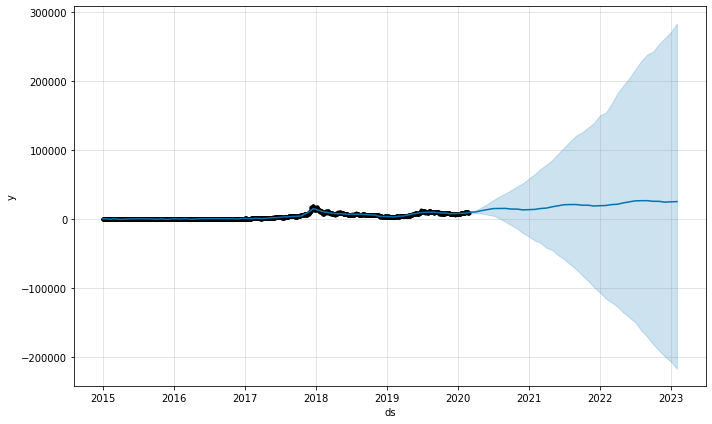

In [15]:
ax = model.plot(forecast);

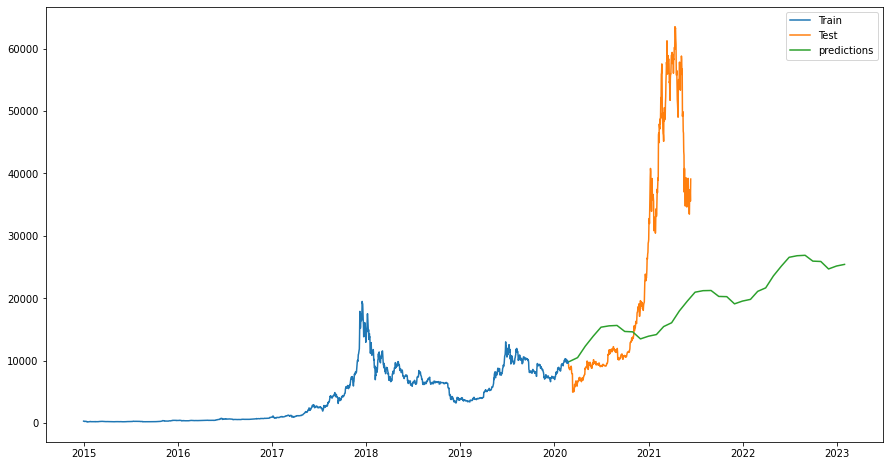

In [16]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

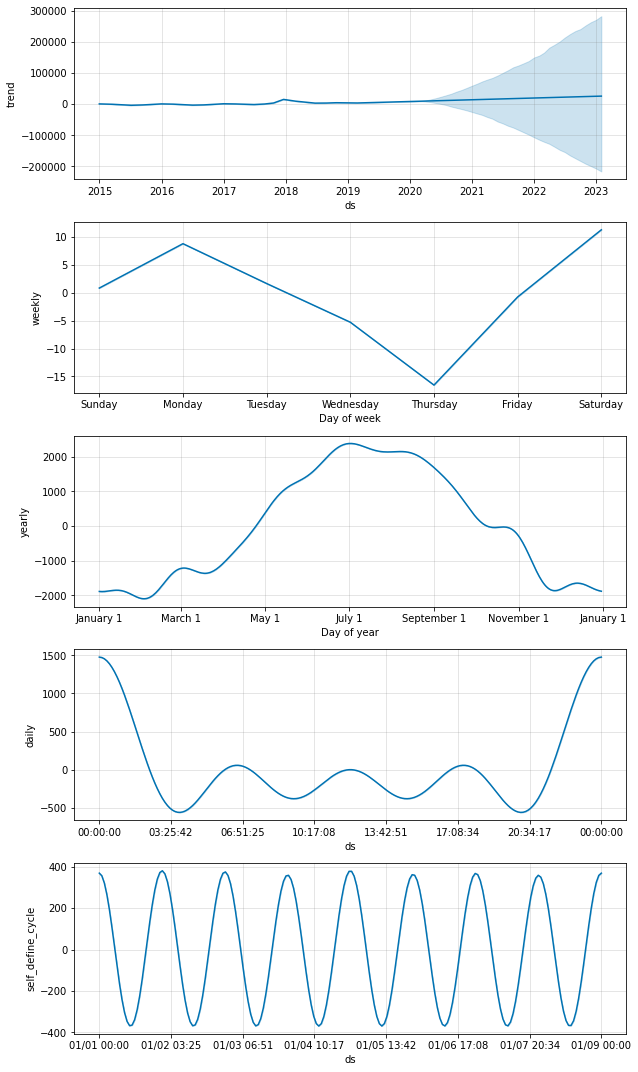

In [17]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [18]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-01 00:00:00 and 2019-02-24 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1090,2020-02-20,-2653.370090,-31554.107879,30408.886050,9608.475586,2019-02-24
1091,2020-02-21,-2624.984450,-32018.400719,31825.267931,9686.441406,2019-02-24
1092,2020-02-22,-2579.390082,-31640.944058,30656.005354,9663.181641,2019-02-24
1093,2020-02-23,-2550.895060,-32237.569556,31097.022901,9924.515625,2019-02-24
1094,2020-02-24,-2545.176066,-31928.716389,30413.692425,9650.174805,2019-02-24


In [20]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,9.278144e+05,963.231252,805.010041,0.150224,0.112743,0.899083
1,38 days,9.930138e+05,996.500761,826.216634,0.155078,0.115733,0.896024
2,39 days,1.052895e+06,1026.106659,845.942971,0.159946,0.116234,0.896024
3,40 days,1.111605e+06,1054.326950,863.421090,0.164505,0.117711,0.896024
4,41 days,1.176506e+06,1084.668566,882.236214,0.168944,0.118359,0.889908


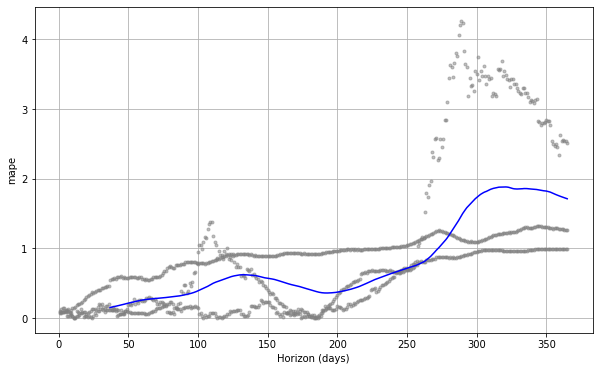

In [21]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [22]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [23]:
m.fit(train_df)

In [24]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as bitcoin:
    json.dump(model_to_json(m),bitcoin)

In [25]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1913,2022-09-30,26543.185246,-165724.779993,217024.762268
1914,2022-10-31,26845.780016,-177883.977874,227752.498126
1915,2022-11-30,25121.050695,-194869.791782,237434.761906
1916,2022-12-31,26535.548874,-203497.197131,249905.825999
1917,2023-01-31,26534.298831,-215688.565485,260038.172219


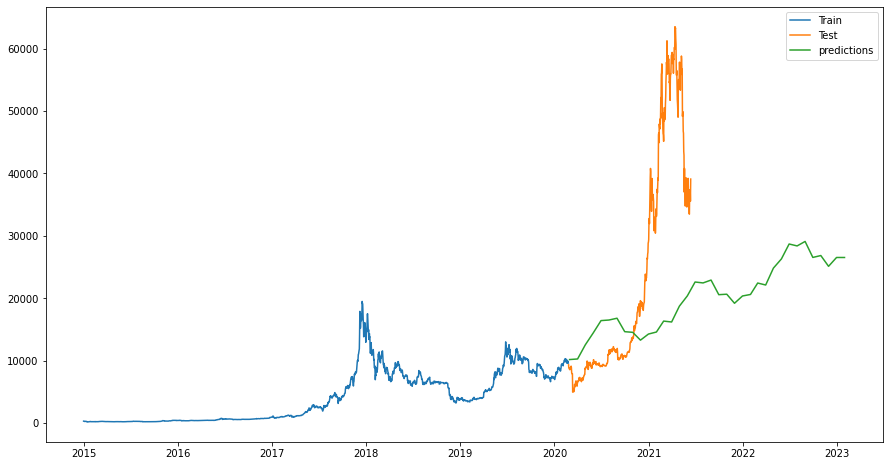

In [26]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [27]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-01 00:00:00 and 2019-02-24 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,2.570649e+06,1603.324209,1291.111848,0.187519,0.194179,0.455657
1,38 days,2.565342e+06,1601.668646,1308.083235,0.192458,0.201671,0.446483
2,39 days,2.533941e+06,1591.835653,1318.947420,0.196659,0.208425,0.437309
3,40 days,2.501472e+06,1581.604151,1330.505163,0.200912,0.216788,0.428135
4,41 days,2.494570e+06,1579.420938,1344.449981,0.204941,0.216827,0.418960


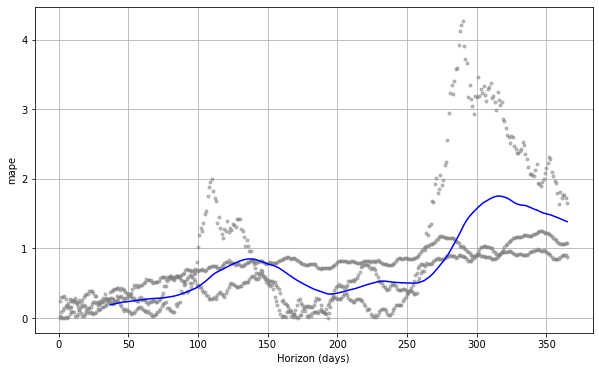

In [29]:
plot_cross_validation_metric(cv_results, metric='mape');